<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4662 entries, 0 to 4661
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       4662 non-null   object 
 1   High       4662 non-null   float64
 2   Low        4662 non-null   float64
 3   Open       4662 non-null   float64
 4   Close      4662 non-null   float64
 5   Adj Close  4662 non-null   float64
 6   count      4662 non-null   float64
dtypes: float64(6), object(1)
memory usage: 255.1+ KB


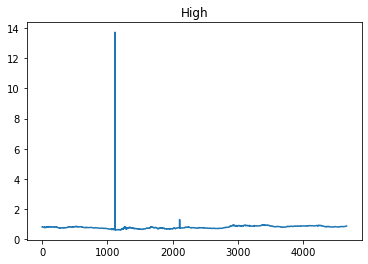

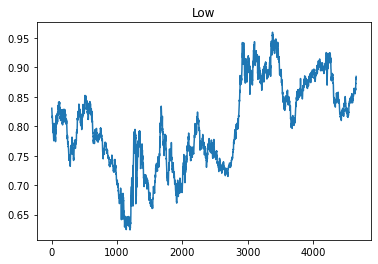

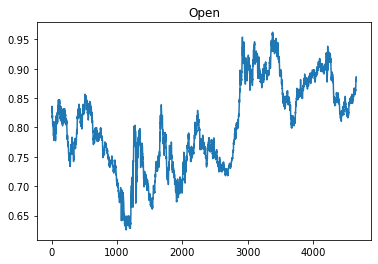

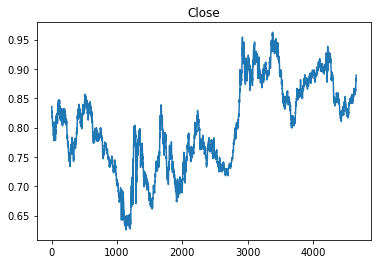

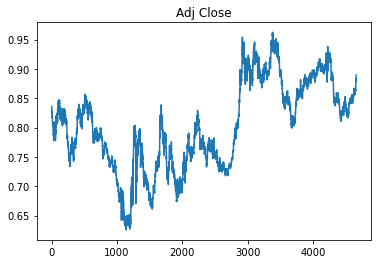

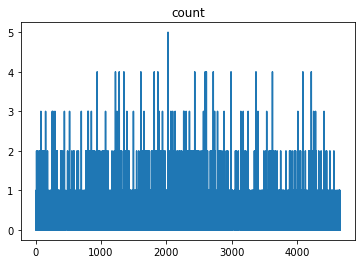

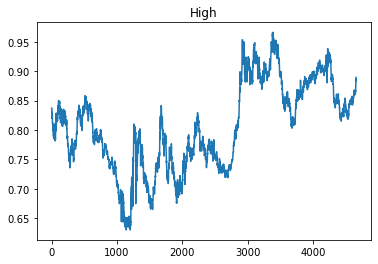

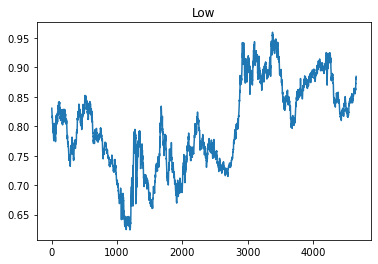

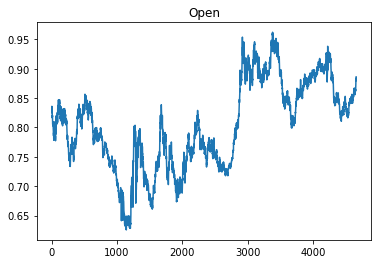

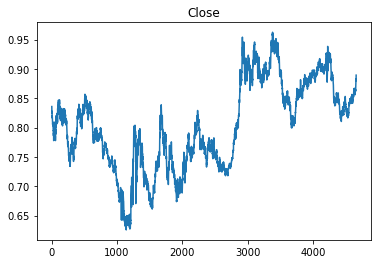

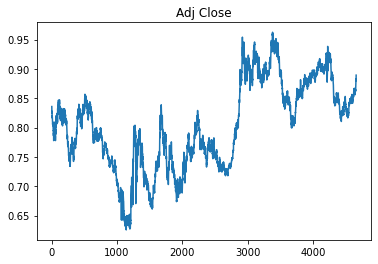

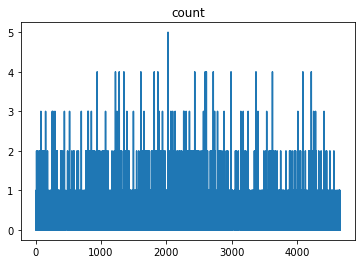

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("../data_collection/data.csv")


df.drop("Volume",1,inplace=True)

df.info()

for i in df.columns[1:]:
    df[i].plot()
    plt.title(i)
    plt.show()
    

df.drop(df[df.High > 1].index, inplace=True)

for i in df.columns[1:]:
    df[i].plot()
    plt.title(i)
    plt.show()

In [2]:
pd.concat([df[df["count"] > 0].mean(), df[df["count"] < 1].mean()], 1).rename(columns={0:"daywtihexplanation", 1:"daywithoutexplanation"})

,daywtihexplanation,daywithoutexplanation
High,0.800340,0.807893
Low,0.793938,0.802089
Open,0.797151,0.804968
Close,0.797126,0.804952
Adj Close,0.797126,0.804952
count,1.301786,0.000000


In [3]:
df["count1"] = df["count"].apply(lambda x: 1 if x > 0 else 0)

In [4]:
df[["Close", "count","count1"]].corr()

,Close,count,count1
Close,1.000000,-0.049292,-0.044902
count,-0.049292,1.000000,0.879066
count1,-0.044902,0.879066,1.000000


In [5]:
#https://stackoverflow.com/questions/25571882/pandas-columns-correlation-with-statistical-significance
from scipy.stats import pearsonr
import numpy as np
rho = df[["Close", "count","count1"]].corr()
pval = df[["Close", "count","count1"]].corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
p = pval.applymap(lambda x: ''.join(['*' for t in [0.01,0.05,0.1] if x<=t]))
rho.round(2).astype(str) + p

,Close,count,count1
Close,1.0***,-0.05***,-0.04***
count,-0.05***,1.0***,0.88***
count1,-0.04***,0.88***,1.0***


In [7]:
df.count1.value_counts()

0    3540
1    1120
Name: count1, dtype: int64

<AxesSubplot:>

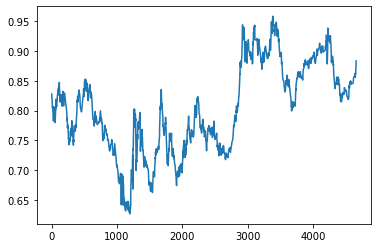

In [8]:
df[df.count1 == 1].Close.plot()

<AxesSubplot:>

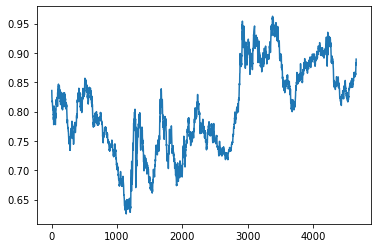

In [9]:
df[df.count1 == 0].Close.plot()

In [10]:
from pmdarima import auto_arima

In [4]:
dfm = df.drop(["Adj Close"],1)
dfm.Date = pd.to_datetime(dfm.Date)
dfm.set_index("Date", drop= "Date", inplace=True)
dfm.info()
dfi = pd.date_range("2003-12-01", "2021-11-12",freq="B", name="Date").to_frame()
dfi= dfi.drop("Date",1)
df2 = pd.merge(dfi, dfm, how="left", on="Date" ).fillna(method="bfill")
df2

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4660 entries, 2003-12-01 to 2021-11-22
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   High    4660 non-null   float64
 1   Low     4660 non-null   float64
 2   Open    4660 non-null   float64
 3   Close   4660 non-null   float64
 4   count   4660 non-null   float64
 5   count1  4660 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 254.8 KB


,High,Low,Open,Close,count,count1
Date,,,,,,
2003-12-01,0.83724,0.83056,0.83098,0.83577,0.0,0.0
2003-12-02,0.83710,0.82583,0.83605,0.82720,0.0,0.0
2003-12-03,0.82802,0.82440,0.82713,0.82488,0.0,0.0
2003-12-04,0.83029,0.82345,0.82508,0.82775,1.0,1.0
2003-12-05,0.82878,0.82028,0.82795,0.82055,1.0,1.0
...,...,...,...,...,...,...
2021-11-08,0.86567,0.86240,0.86442,0.86439,0.0,0.0
2021-11-09,0.86429,0.86140,0.86291,0.86270,0.0,0.0
2021-11-10,0.86855,0.86220,0.86254,0.86240,0.0,0.0


In [4]:
arima_model = auto_arima(df['Close'], start_p = 1, d=1, start_q = 1, 
                          max_p = 5, max_q = 5, max_d=5, m = 5, 
                          start_P = 0, D=1, start_Q=0, max_P=5, max_D=5, max_Q=5,
                          seasonal = True, 
                          trace = True, 
                          error_action ='ignore',   
                          suppress_warnings = True,  
                          stepwise = True, n_fits=50, freq = "B")    
arima_model.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,0)[5]             : AIC=-31964.796, Time=0.68 sec
 ARIMA(0,1,0)(0,1,0)[5]             : AIC=-31806.317, Time=1.01 sec
 ARIMA(1,1,0)(1,1,0)[5]             : AIC=-33237.222, Time=1.81 sec
 ARIMA(0,1,1)(0,1,1)[5]             : AIC=inf, Time=3.01 sec
 ARIMA(1,1,0)(0,1,0)[5]             : AIC=-31922.731, Time=0.30 sec
 ARIMA(1,1,0)(2,1,0)[5]             : AIC=-33825.999, Time=1.53 sec
 ARIMA(1,1,0)(3,1,0)[5]             : AIC=-34109.941, Time=2.51 sec
 ARIMA(1,1,0)(4,1,0)[5]             : AIC=-34271.861, Time=6.65 sec
 ARIMA(1,1,0)(5,1,0)[5]             : AIC=-34364.541, Time=3.30 sec
 ARIMA(1,1,0)(5,1,1)[5]             : AIC=-34370.009, Time=5.14 sec
 ARIMA(1,1,0)(4,1,1)[5]             : AIC=inf, Time=12.04 sec
 ARIMA(1,1,0)(5,1,2)[5]             : AIC=inf, Time=15.32 sec
 ARIMA(1,1,0)(4,1,2)[5]             : AIC=inf, Time=14.52 sec
 ARIMA(0,1,0)(5,1,1)[5]             : AIC=-34241.589, Time=4.62 sec
 ARIMA(2,1,0)(5,1,1)[5]       

<class 'statsmodels.iolib.summary.Summary'>
"""
                                         SARIMAX Results                                         
=================================================================================================
Dep. Variable:                                         y   No. Observations:                 4660
Model:             SARIMAX(2, 1, 0)x(0, 1, [1, 2, 3], 5)   Log Likelihood               17449.460
Date:                                   Mon, 06 Dec 2021   AIC                         -34886.919
Time:                                           00:25:26   BIC                         -34848.246
Sample:                                                0   HQIC                        -34873.316
                                                  - 4660                                         
Covariance Type:                                     opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1715      0.004    -48.286      0.000      -0.179      -0.165
ar.L2         -0.0812      0.010     -7.982      0.000      -0.101      -0.061
ma.S.L5       -0.8625      0.009   -100.104      0.000      -0.879      -0.846
ma.S.L10      -0.0228      0.011     -2.100      0.036      -0.044      -0.002
ma.S.L15      -0.0142      0.009     -1.584      0.113      -0.032       0.003
sigma2      3.237e-05   1.63e-07    198.447      0.000    3.21e-05    3.27e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.24   Jarque-Bera (JB):            627487.08
Prob(Q):                              0.63   Prob(JB):                         0.00
Heteroskedasticity (H):               0.31   Skew:                            -1.50
Prob(H) (two-sided):                  0.00   Kurtosis:                        59.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [8]:
from statsmodels.tsa.statespace.sarimax import SARIMAX 
from statsmodels.tools.eval_measures import rmse

In [13]:
X_train = df2.iloc[:-20]
X_test = df2.iloc[-20:]


  
model = SARIMAX(X_train['Close'],
                order = (2, 1, 0),  
                seasonal_order =(5, 1, [1,2,3], 5), freq = "B") 
  
result = model.fit() 
result.summary() 

C:\Users\User\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                         SARIMAX Results                                         
=================================================================================================
Dep. Variable:                                     Close   No. Observations:                 4665
Model:             SARIMAX(2, 1, 0)x(5, 1, [1, 2, 3], 5)   Log Likelihood               17578.095
Date:                                   Wed, 08 Dec 2021   AIC                         -35134.190
Time:                                           01:35:41   BIC                         -35063.278
Sample:                                       12-01-2003   HQIC                        -35109.247
                                            - 10-15-2021                                         
Covariance Type:                                     opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1751      0.005    -32.639      0.000      -0.186      -0.165
ar.L2         -0.0335      0.009     -3.527      0.000      -0.052      -0.015
ar.S.L5       -0.8451      0.830     -1.019      0.308      -2.471       0.781
ar.S.L10      -0.6210      0.533     -1.166      0.244      -1.665       0.423
ar.S.L15      -0.1735      0.082     -2.104      0.035      -0.335      -0.012
ar.S.L20      -0.0896      0.097     -0.923      0.356      -0.280       0.101
ar.S.L25      -0.0353      0.051     -0.687      0.492      -0.136       0.065
ma.S.L5       -0.1080      0.830     -0.130      0.897      -1.735       1.519
ma.S.L10      -0.2024      0.718     -0.282      0.778      -1.610       1.205
ma.S.L15      -0.4472      0.452     -0.989      0.323      -1.333       0.439
sigma2      3.092e-05   1.69e-07    183.413      0.000    3.06e-05    3.13e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):            806675.28
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               0.33   Skew:                            -1.42
Prob(H) (two-sided):                  0.00   Kurtosis:                        67.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

SARIMA RMSE Error: 0.003546411923326811


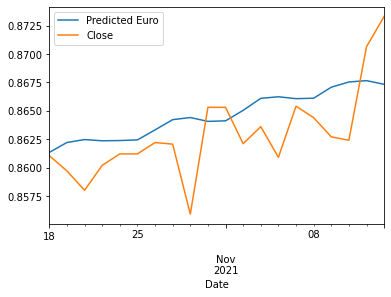

In [14]:

#Prediction
start_index = X_test.index[0]
end_index = X_test.index[len(X_test)-1]
prediction = result.predict(start_index, end_index).rename('Predicted Euro') 
#Rename the column

# plot predictions and actual values 
prediction.plot(legend = True) 
X_test['Close'].plot(legend = True)
error1 = rmse(X_test['Close'], prediction)
print(f'SARIMA RMSE Error: {error1}')

In [15]:
X_train = df2.iloc[:-20]
X_test = df2.iloc[-20:]


  
model = SARIMAX(X_train['Close'], exog=X_train["count"],
                order = (2, 1, 0),  
                seasonal_order =(5, 1, [1,2,3], 5), freq = "B") 
  
result = model.fit() 
result.summary() 

C:\Users\User\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                         SARIMAX Results                                         
=================================================================================================
Dep. Variable:                                     Close   No. Observations:                 4665
Model:             SARIMAX(2, 1, 0)x(5, 1, [1, 2, 3], 5)   Log Likelihood               17578.324
Date:                                   Wed, 08 Dec 2021   AIC                         -35132.648
Time:                                           01:36:24   BIC                         -35055.290
Sample:                                       12-01-2003   HQIC                        -35105.438
                                            - 10-15-2021                                         
Covariance Type:                                     opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
count      -8.366e-05   8.89e-05     -0.941      0.346      -0.000    9.05e-05
ar.L1         -0.1757      0.005    -32.323      0.000      -0.186      -0.165
ar.L2         -0.0337      0.010     -3.494      0.000      -0.053      -0.015
ar.S.L5       -0.8456      0.820     -1.031      0.303      -2.453       0.762
ar.S.L10      -0.6210      0.527     -1.178      0.239      -1.654       0.412
ar.S.L15      -0.1740      0.081     -2.140      0.032      -0.333      -0.015
ar.S.L20      -0.0896      0.097     -0.929      0.353      -0.279       0.100
ar.S.L25      -0.0358      0.051     -0.701      0.484      -0.136       0.064
ma.S.L5       -0.1078      0.821     -0.131      0.896      -1.716       1.501
ma.S.L10      -0.2022      0.706     -0.287      0.774      -1.585       1.181
ma.S.L15      -0.4476      0.447     -1.001      0.317      -1.324       0.428
sigma2      3.091e-05   1.69e-07    183.309      0.000    3.06e-05    3.12e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):            807510.27
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               0.33   Skew:                            -1.42
Prob(H) (two-sided):                  0.00   Kurtosis:                        67.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

SARIMA RMSE Error: 0.0035264116227466742


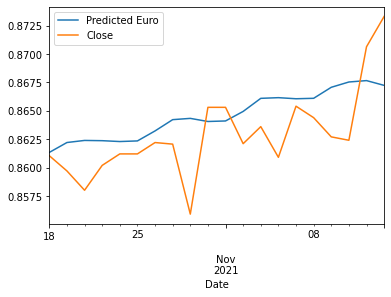

In [16]:
#Prediction
start_index = X_test.index[0]
end_index = X_test.index[len(X_test)-1]
exog_forecast = X_test[['count']] 
prediction = result.predict(start_index, end_index, exog=exog_forecast).rename('Predicted Euro') 
#Rename the column

# plot predictions and actual values 
prediction.plot(legend = True) 
X_test['Close'].plot(legend = True)
error1 = rmse(X_test['Close'], prediction)
print(f'SARIMA RMSE Error: {error1}')

In [17]:

X_train = df2.iloc[:-20]
X_test = df2.iloc[-20:]


  
model = SARIMAX(X_train['Close'], exog=X_train["count1"],
                order = (2, 1, 0),  
                seasonal_order =(5, 1, [1,2,3], 5), freq = "B") 
  
result = model.fit() 
result.summary() 

C:\Users\User\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                         SARIMAX Results                                         
=================================================================================================
Dep. Variable:                                     Close   No. Observations:                 4665
Model:             SARIMAX(2, 1, 0)x(5, 1, [1, 2, 3], 5)   Log Likelihood               17676.330
Date:                                   Wed, 08 Dec 2021   AIC                         -35328.660
Time:                                           01:37:48   BIC                         -35251.301
Sample:                                       12-01-2003   HQIC                        -35301.450
                                            - 10-15-2021                                         
Covariance Type:                                     opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
count1     -7.959e-05      0.000     -0.572      0.568      -0.000       0.000
ar.L1         -0.1735      0.005    -35.135      0.000      -0.183      -0.164
ar.L2         -0.0021      0.009     -0.234      0.815      -0.019       0.015
ar.S.L5       -1.2244      0.090    -13.674      0.000      -1.400      -1.049
ar.S.L10      -0.7261      0.094     -7.696      0.000      -0.911      -0.541
ar.S.L15       0.0043      0.021      0.199      0.842      -0.038       0.046
ar.S.L20       0.0290      0.019      1.499      0.134      -0.009       0.067
ar.S.L25       0.0370      0.014      2.697      0.007       0.010       0.064
ma.S.L5        0.2459      0.089      2.758      0.006       0.071       0.421
ma.S.L10      -0.4873      0.071     -6.822      0.000      -0.627      -0.347
ma.S.L15      -0.7386      0.097     -7.623      0.000      -0.928      -0.549
sigma2      2.956e-05   1.68e-07    176.368      0.000    2.92e-05    2.99e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):            882720.87
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               0.33   Skew:                            -1.54
Prob(H) (two-sided):                  0.00   Kurtosis:                        70.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

SARIMA RMSE Error: 0.004200251428730617


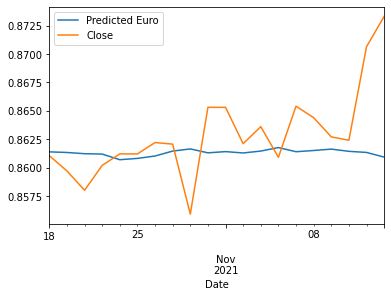

In [18]:
#Prediction
start_index = X_test.index[0]
end_index = X_test.index[len(X_test)-1]
exog_forecast = X_test[['count']] 
prediction = result.predict(start_index, end_index, exog=exog_forecast).rename('Predicted Euro') 
#Rename the column

# plot predictions and actual values 
prediction.plot(legend = True) 
X_test['Close'].plot(legend = True)
error1 = rmse(X_test['Close'], prediction)
print(f'SARIMA RMSE Error: {error1}')

In [6]:
X_train = df2.iloc[:-20]
X_test = df2.iloc[-20:]


  
model = SARIMAX(X_train['Close'] ,
                order = (1, 1, 0),  
                seasonal_order =(5, 1, [1], 10), freq = "B") 
  
result = model.fit() 
result.summary() 

C:\Users\User\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                Close   No. Observations:                 4665
Model:             SARIMAX(1, 1, 0)x(5, 1, [1], 10)   Log Likelihood               17316.853
Date:                              Wed, 08 Dec 2021   AIC                         -34617.706
Time:                                      01:53:34   BIC                         -34566.142
Sample:                                  12-01-2003   HQIC                        -34599.568
                                       - 10-15-2021                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1658      0.004    -39.655      0.000      -0.174      -0.158
ar.S.L10      -0.9345      0.066    -14.084      0.000      -1.065      -0.804
ar.S.L20      -0.7261      0.055    -13.174      0.000      -0.834      -0.618
ar.S.L30      -0.5487      0.041    -13.511      0.000      -0.628      -0.469
ar.S.L40      -0.3569      0.030    -11.868      0.000      -0.416      -0.298
ar.S.L50      -0.1684      0.016    -10.326      0.000      -0.200      -0.136
ma.S.L10       0.0961      0.067      1.431      0.152      -0.036       0.228
sigma2      3.431e-05   1.78e-07    193.144      0.000     3.4e-05    3.47e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.30   Jarque-Bera (JB):            456854.47
Prob(Q):                              0.59   Prob(JB):                         0.00
Heteroskedasticity (H):               0.33   Skew:                            -1.00
Prob(H) (two-sided):                  0.00   Kurtosis:                        51.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

SARIMA RMSE Error: 0.0033012311865900697


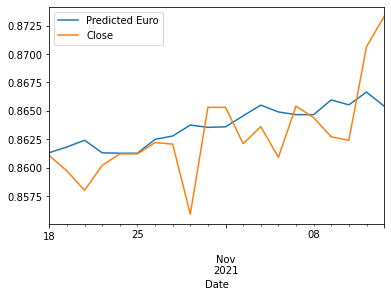

In [9]:
#Prediction
start_index = X_test.index[0]
end_index = X_test.index[len(X_test)-1]
exog_forecast = X_test[['count']] 
prediction = result.predict(start_index, end_index,).rename('Predicted Euro') 
#Rename the column

# plot predictions and actual values 
prediction.plot(legend = True) 
X_test['Close'].plot(legend = True)
error1 = rmse(X_test['Close'], prediction)
print(f'SARIMA RMSE Error: {error1}')

In [10]:
X_train = df2.iloc[:-20]
X_test = df2.iloc[-20:]


  
model = SARIMAX(X_train['Close'] , exog=X_train["count"],
                order = (1, 1, 0),  
                seasonal_order =(5, 1, [1], 10), freq = "B") 
  
result = model.fit() 
result.summary() 

C:\Users\User\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                Close   No. Observations:                 4665
Model:             SARIMAX(1, 1, 0)x(5, 1, [1], 10)   Log Likelihood               17317.006
Date:                              Wed, 08 Dec 2021   AIC                         -34616.013
Time:                                      01:55:44   BIC                         -34558.003
Sample:                                  12-01-2003   HQIC                        -34595.607
                                       - 10-15-2021                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
count      -5.635e-05   8.56e-05     -0.658      0.511      -0.000       0.000
ar.L1         -0.1664      0.004    -39.025      0.000      -0.175      -0.158
ar.S.L10      -0.9339      0.067    -14.033      0.000      -1.064      -0.803
ar.S.L20      -0.7248      0.055    -13.121      0.000      -0.833      -0.617
ar.S.L30      -0.5473      0.041    -13.461      0.000      -0.627      -0.468
ar.S.L40      -0.3568      0.030    -11.860      0.000      -0.416      -0.298
ar.S.L50      -0.1680      0.016    -10.271      0.000      -0.200      -0.136
ma.S.L10       0.0963      0.067      1.429      0.153      -0.036       0.228
sigma2      3.431e-05   1.78e-07    193.163      0.000     3.4e-05    3.47e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.27   Jarque-Bera (JB):            456898.57
Prob(Q):                              0.60   Prob(JB):                         0.00
Heteroskedasticity (H):               0.33   Skew:                            -1.00
Prob(H) (two-sided):                  0.00   Kurtosis:                        51.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

SARIMA RMSE Error: 0.0033001284197754707


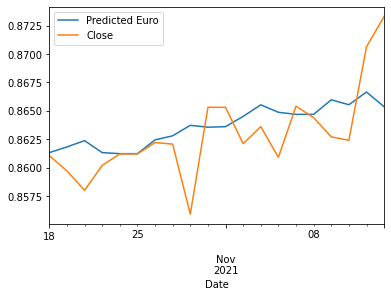

In [11]:
#Prediction
start_index = X_test.index[0]
end_index = X_test.index[len(X_test)-1]
exog_forecast = X_test[['count']] 
prediction = result.predict(start_index, end_index, exog=exog_forecast).rename('Predicted Euro') 
#Rename the column

# plot predictions and actual values 
prediction.plot(legend = True) 
X_test['Close'].plot(legend = True)
error1 = rmse(X_test['Close'], prediction)
print(f'SARIMA RMSE Error: {error1}')

In [23]:
X_train = df2.iloc[:-20]
X_test = df2.iloc[-20:]


  
model = SARIMAX(X_train['Close'] , exog=X_train["count1"],
                order = (1, 1, 0),  
                seasonal_order =(5, 1, [1], 10), freq = "B") 
  
result = model.fit() 
result.summary() 

C:\Users\User\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                Close   No. Observations:                 4665
Model:             SARIMAX(1, 1, 0)x(5, 1, [1], 10)   Log Likelihood               17316.800
Date:                              Mon, 06 Dec 2021   AIC                         -34615.601
Time:                                      01:00:29   BIC                         -34557.591
Sample:                                  12-01-2003   HQIC                        -34595.195
                                       - 10-15-2021                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
count1     -6.081e-05      0.000     -0.450      0.653      -0.000       0.000
ar.L1         -0.1660      0.004    -39.696      0.000      -0.174      -0.158
ar.S.L10      -0.9354      0.067    -14.041      0.000      -1.066      -0.805
ar.S.L20      -0.7263      0.055    -13.141      0.000      -0.835      -0.618
ar.S.L30      -0.5485      0.041    -13.480      0.000      -0.628      -0.469
ar.S.L40      -0.3570      0.030    -11.859      0.000      -0.416      -0.298
ar.S.L50      -0.1682      0.016    -10.297      0.000      -0.200      -0.136
ma.S.L10       0.0972      0.067      1.440      0.150      -0.035       0.230
sigma2      3.431e-05   1.79e-07    191.301      0.000     3.4e-05    3.47e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.29   Jarque-Bera (JB):            457394.38
Prob(Q):                              0.59   Prob(JB):                         0.00
Heteroskedasticity (H):               0.33   Skew:                            -1.00
Prob(H) (two-sided):                  0.00   Kurtosis:                        51.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

SARIMA RMSE Error: 0.0032965269148706676


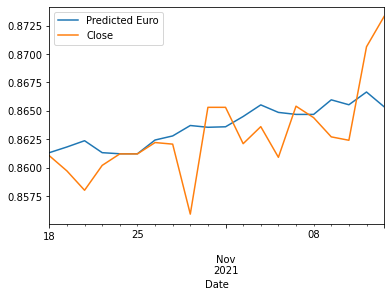

In [24]:
#Prediction
start_index = X_test.index[0]
end_index = X_test.index[len(X_test)-1]
exog_forecast = X_test[['count']] 
prediction = result.predict(start_index, end_index, exog=exog_forecast).rename('Predicted Euro') 
#Rename the column

# plot predictions and actual values 
prediction.plot(legend = True) 
X_test['Close'].plot(legend = True)
error1 = rmse(X_test['Close'], prediction)
print(f'SARIMA RMSE Error: {error1}')